# Exploring the UTx000 Extension Beacon Data
(See [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [69]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math

from datetime import datetime, timedelta

# Data Import

In [4]:
beacon_data = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col=0,parse_dates=True)
beacon_data.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap
timestamp,,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,81.2,2.77440,0.775262,13.9663,NaN,11.900343,11.320369,11.075540,0.733881,1.149634,1.935875,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:02:00,82.8,2.77440,0.798162,13.9555,NaN,12.730011,12.184753,11.910685,0.800211,1.198782,1.979986,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:04:00,84.2,2.77440,0.770355,13.8341,NaN,13.183286,12.706129,12.422126,0.840419,1.234695,2.013414,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:06:00,82.0,2.77440,0.780169,14.0344,NaN,12.301532,11.367415,11.062862,0.735991,1.104990,1.886775,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:08:00,86.6,4.07184,0.781805,13.7661,NaN,12.932402,11.947330,11.611038,0.780179,1.128095,1.905629,27.5,47.05,1,kyj367pi,24,10


We also need some important information regarding shipment dates to calculate completeness. So we import the beacon-specific ```id_crossover``` file.

In [5]:
details = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='beacon',index_col=1,
                       parse_dates=['start_date','end_date','move_date'])
details.head()

,redcap,beacon,start_date,end_date,move_date,return_date,lat,long,original_address,volume,...,no2_sensor,original_start,original_end,original_move,lat2,long2,second address,lat3,long3,third address
beiwe,,,,,,,,,,,,,,,,,,,,,
kyj367pi,10.0,1.0,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.295025,-97.744222,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080.0,...,Yes,2020-06-15,NaT,2020-09-14,30.312614,-97.732338,"4605 Avenue A APT 214, Austin, TX, 78751",NaN,NaN,NaN
745vq78e,55.0,5.0,2020-06-09 10:21:00,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,"18207 Branson Falls San Antonio, TX 78255",1188.0,...,Yes,2020-06-15,NaT,2020-08-17,NaN,NaN,NaN,NaN,NaN,NaN
itmylz3g,61.0,6.0,2020-06-17 14:08:00,2020-09-01,NaT,2020-09-01,29.855371,-95.741200,"5403 Dunsmore Harbor Ln, Katy, TX 77449",1188.0,...,Yes,2020-06-15,2020-09-11,2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN
zdpffrox,0.0,7.0,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365.0,...,Yes,2020-06-06,2020-09-03,2020-07-31,30.367307,-97.793199,"6500 champion grandview way apt 26104 Austin, ...",NaN,NaN,NaN
xlw5ntd5,43.0,10.0,2020-06-08 13:19:00,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,"6704 bramber ln, austin, tx 78754",1188.0,...,Yes,2020-06-08,NaT,2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN


# Base Analysis
Here we look at the raw, unaltered data in order to understand:
- which participants submitted data?
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- how much data were collected?
- what are typical measurements and what does this say?
- are there any misbehaving sensors?

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

from joypy import joyplot

## Which participants submitted data?
Here we look at what beacons are represented in each of the three types of beacon datasets:
1. All available beacon data
2. Beacon data filtered by Fitbit-recorded sleep events when home (cross-references with GPS)
3. Beacon data from 2) further filtered by completed EMAs the next morning.

### All Available beacon data

In [7]:
print(f'Number of beacons represented:',len(beacon_data['beacon'].unique()))
print(f'\tBeacons:',beacon_data['beacon'].unique())
print(f'\tBeiwe:', beacon_data['beiwe'].unique())

Number of beacons represented: 22
	Beacons: [ 1  5 10 15 16 17 19 21 22 24 25 26 28 29 30 32 34 36 38 40 44 46]
	Beiwe: ['kyj367pi' '745vq78e' 'xlw5ntd5' '9jtzsuu8' 'e73a1pd5' '9xmhtq74'
 'qh34m4r9' 'lkkjddam' 'xxvnhauv' 'xdbdrk6e' 'vr9j5rry' 'awa8uces'
 'hxj6brwj' 'tmexej5v' 'idbkjh8u' '2xtqkfz1' 'rnse61g4' 'tlmlq19s'
 'olaxadz5' 'i4w8dx6l' '4i7679py' 'nvtfpaor']


### When participants are home and asleep

In [8]:
df = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                             index_col=0)
print(f'Number of beacons represented:',len(df['beacon'].unique()))
print(f'\tBeacons:',df['beacon'].unique())
print(f'\tBeiwe:', df['beiwe'].unique())

Number of beacons represented: 17
	Beacons: [21 19 29 10  1 16  5 26 25 38 34 44 15 24 28 36 17]
	Beiwe: ['lkkjddam' 'qh34m4r9' 'tmexej5v' 'xlw5ntd5' 'kyj367pi' 'e73a1pd5'
 '745vq78e' 'awa8uces' 'vr9j5rry' 'olaxadz5' 'rnse61g4' '4i7679py'
 '9jtzsuu8' 'xdbdrk6e' 'hxj6brwj' 'tlmlq19s' '9xmhtq74']


### When participants are home, asleep, and filled out survey

In [9]:
df = pd.read_csv('../data/processed/beacon-fb_ema_and_gps_filtered-ux_s20.csv',
                             index_col=0)
print(f'Number of beacons represented:',len(df['beacon'].unique()))
print(f'\tBeacons:',df['beacon'].unique())
print(f'\tBeiwe:', df['beiwe'].unique())

Number of beacons represented: 16
	Beacons: [21 19 29 10  1  5 26 25 38 34 44 15 24 28 36 17]
	Beiwe: ['lkkjddam' 'qh34m4r9' 'tmexej5v' 'xlw5ntd5' 'kyj367pi' '745vq78e'
 'awa8uces' 'vr9j5rry' 'olaxadz5' 'rnse61g4' '4i7679py' '9jtzsuu8'
 'xdbdrk6e' 'hxj6brwj' 'tlmlq19s' '9xmhtq74']


## What data are available?
Here we look at some basic visualizations to get a sense of the data collected

### Heatmaps by Sensor
These heatmaps show the values measured by a specific sensor on all of the beacons, but are more useful for determining when data are available.

In [10]:
def heatmaps_by_sensor(df=beacon_data,var_list=['pm2p5_mass','co2','co','no2','temperature_c','lux'],limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]],log_scale=False,save=False):
    """
    Plots heatmaps for sensors in var_list
    """
    for variable, limits in zip(var_list, limit_list):
        print(f'Working for {variable}')
        heatmap_df = pd.DataFrame()
        for beacon in df['beacon'].unique():
            data_by_beacon = df[df['beacon'] == beacon]
            #data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
            data_by_beacon = data_by_beacon.resample('1h').mean()
            sdate = datetime(2020,6,1)
            edate = datetime(2020,9,1)
            data_by_beacon = data_by_beacon[sdate:edate]
            heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
            heatmap_df.rename(columns={variable:beacon}, inplace=True)

        print(f'\tData collected')
        fig, ax = plt.subplots(figsize=(20,15))
        df_to_plot = heatmap_df.T
        print(f'\tPlotting')
        if log_scale:
            sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        else:
            sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))

        x_labels = []
        for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
            x_labels.append(d.strftime('%m-%d'))

        ax.set_xticklabels(x_labels)

        plt.show()
        plt.close()

In [11]:
#heatmaps_by_sensor()

### Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

In [12]:
def operation_and_data(df=beacon_data,sensors=['co2','pm2p5_mass','lux','no2','co','tvoc'],save=False):
    """
    
    """
    fig, axes = plt.subplots(10,5,figsize=(30,15),sharex="col",sharey='row')
    sensor_datapoints_dict = {'co2':0,'pm2p5_mass':0,'lux':0,'no2':0,'co':0,'tvoc':0}
    for bb, ax in enumerate(axes.flat):
        # restricting to participant
        beacon_by_beiwe = df[df['beacon'] == bb]
        if len(beacon_by_beiwe) > 2:
            beiwe = beacon_by_beiwe['beiwe'][0]
            beacon_by_beiwe = beacon_by_beiwe[details.loc[beiwe,'start_date']:details.loc[beiwe,'end_date']]
            limits = [-50,0,-10,-1000,-1000,-50]
            # Getting overall percentage of data completion
            total_datapoints = (details.loc[beiwe,'return_date'] - details.loc[beiwe,'start_date'] + timedelta(days=1)).days
            # x24 x60 to get into minutes, /5 for interverals, x6 for number of sensors
            total_datapoints = total_datapoints * 24 * 60 / 5 * len(sensors)
            available_datapoints = 0
            for sensor in sensors:
                available_datapoints += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
                sensor_datapoints_dict[sensor] += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
            total_percent = round(available_datapoints / total_datapoints * 100,1)

            i = 1
            for sensor, limit in zip(sensors,limits):
                beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
                ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
                i += 1
            # plotting start and stop dates
            ax.plot([details.loc[beiwe,'start_date'],details.loc[beiwe,'start_date']],[0,6],color='black',linestyle='dashed')
            ax.plot([details.loc[beiwe,'return_date']+timedelta(days=1),details.loc[beiwe,'return_date']+timedelta(days=1)],[0,6],color='black',linestyle='dashed')
            ax.text(datetime(2020,6,10),7,f'{beiwe}, B{bb}, {total_percent}%',va='center',ha='left')
            ax.set_ylim([0.5,7.5])
            ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
            ax.set_yticks(np.arange(1,7,1))
            ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
            for spine in ["top","right"]:
                ax.spines[spine].set_visible(False)
        else:
            ax.text(datetime(2020,6,10),7,f'B{bb}',va='center',ha='left')
            for spine in ["top","right"]:
                ax.spines[spine].set_visible(False)

    plt.subplots_adjust(hspace=0.1,wspace=0)
    if save:
        plt.savefig('../reports/utx000_initial_update/figures/time-beacon-sensor-operation-comprehensive.pdf')
        
    plt.show()
    plt.close()
    
    return total_datapoints, sensor_datapoints_dict

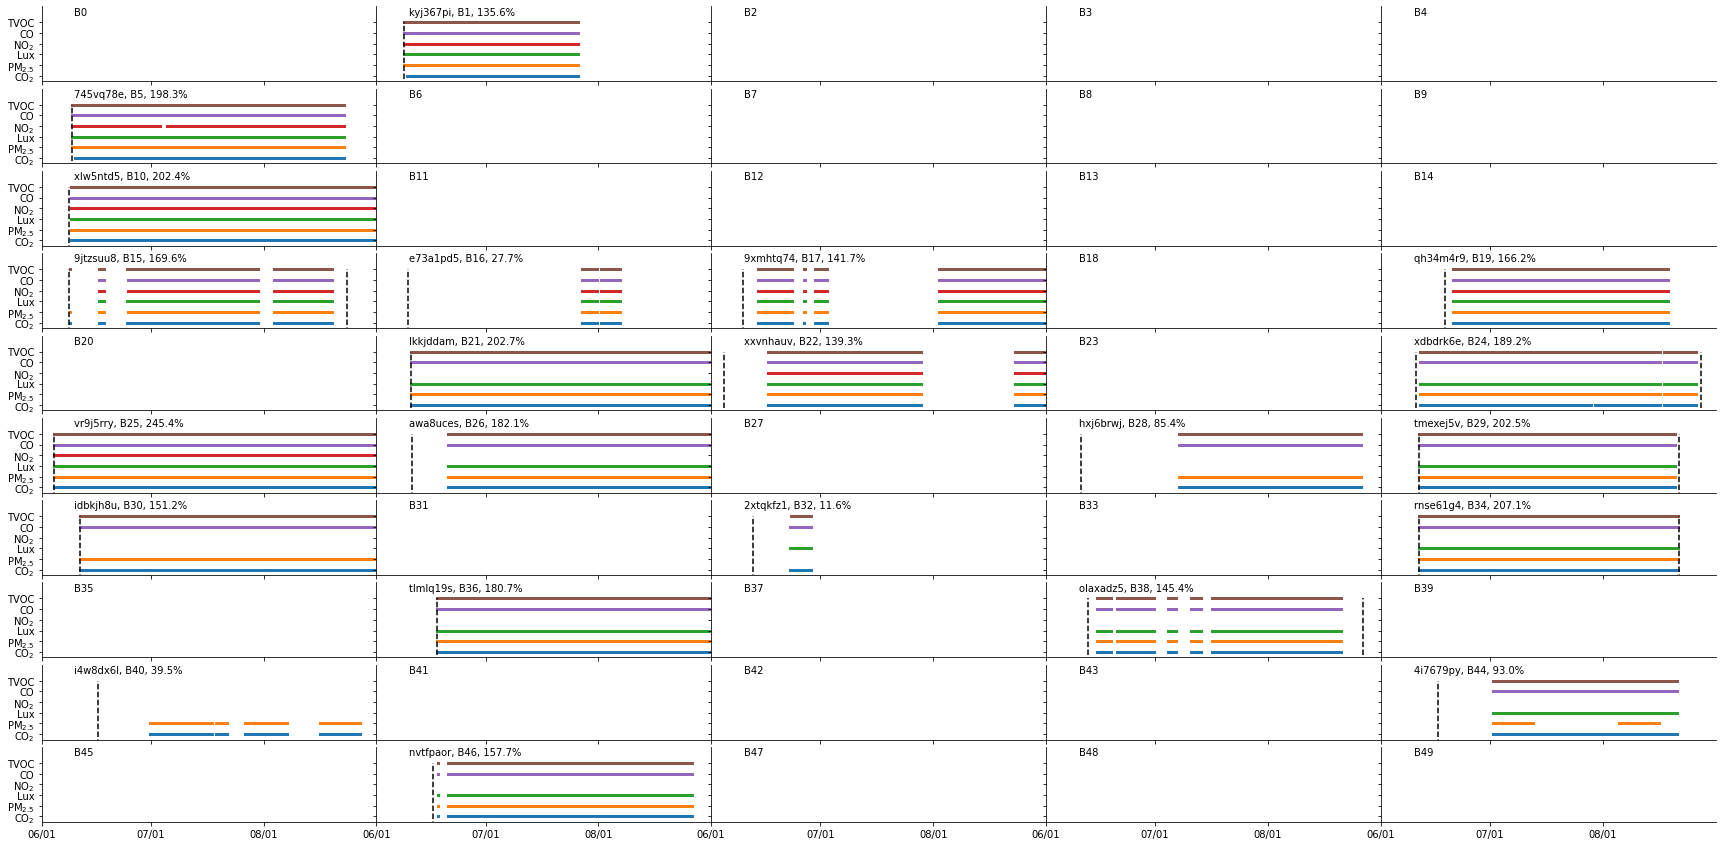

In [13]:
sensors = ['co2','pm2p5_mass','lux','no2','co','tvoc']
total_datapoints, sensor_datapoints_dict = operation_and_data(sensors=sensors)

### Heatmap per beacon
Now we can look at individual beacons and see how well they recorded during a specific time period. 

In [14]:
def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

<div class="alert alert-block alert-success">
    We are looking for a good summary of a week's worth of data. Looks:
    <ul>
        <li>week of July 6 is a good place to start</li>
        <li>Beacon 19</li>
    </ul>
    </div>

In [15]:
def heatmap_per_beacon(df=beacon_data,start_date=datetime(2020,7,6),end_date=datetime(2020,7,14),save=False):
    """
    Plots all beaecon data for a certain beacons during a specified time
    """
    for bb in df['beacon'].unique():
        beacon_bb = df[df['beacon'] == bb][start_date:end_date]
        if len(beacon_bb['no2']) > 10:
            print(f'{bb}:')
            beacon_bb = beacon_bb.resample('60T').mean()
            beacon_bb_pollutants = beacon_bb[['co2','pm2p5_mass','no2','co','tvoc','lux','temperature_c']]
            fig, axes = plt.subplots(7,1,figsize=(12,8),sharex=True)
            ylabels = ['CO$_2$',
                       'PM$_{2.5}$',
                       'NO$_2$',
                       'CO',
                       'TVOC',
                       'Light',
                       'T']
            cbar_ticks = [np.arange(400,1200,200),
                          np.arange(0,40,10),
                          np.arange(0,120,50),
                          np.arange(0,15,4),
                          np.arange(0,800,100),
                          np.arange(0,250,50),
                          np.arange(18,32,4)]
            cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.2, 0.4, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.33, 0.66, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.375, 0.75, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.1, 0.31, 1]),
                     create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                     create_cmap(["cyan","blue","green","orange","red"],[0.0, 0.2, 0.4, 0.7, 1])]
            for ax, var, low, high, ylabel, ticks, cmap in zip(axes,beacon_bb_pollutants.columns,[400,0,0,0,0,0,18],[1000,30,100,12,700,200,30],ylabels,cbar_ticks,cmaps):
                sns.heatmap(beacon_bb_pollutants[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
                ax.set_ylabel(ylabel)
                ax.set_yticklabels([''])
                ax.set_xlabel('')

            xlabels = ax.get_xticklabels()
            new_xlabels = []
            for label in xlabels:
                new_xlabels.append(label.get_text()[11:16])

            ax.set_xticklabels(new_xlabels)
            plt.subplots_adjust(hspace=0.1)
            if save:
                plt.savefig('../reports/BuildSys2020/beacon_example.pdf')
            plt.show()
            plt.close()

In [16]:
#heatmap_per_beacon()

## How much data were collected?
Given the study period, we want to know how much of the possible data were collected

### Number of Hours
A nice metric would to be to see how many hours of data were collected. 

The number of hours is calculated as the sum of the hours each sensor on each beacon was operational.

In [17]:
# Number of beacons
n_beacons = len(beacon_data["beacon"].unique())
print(f"Number of beacons: {n_beacons}")
# Getting number of datapoints
n_datapoints = 0
print("Number of datapoints:")
for sensor in ['tvoc','lux','no2','co','co2','pm2p5_mass']:
    data_per_sensor = beacon_data.loc[:,sensor]
    data_per_sensor.dropna(inplace=True)
    print(f'\t{sensor}: {len(data_per_sensor)}')
    n_datapoints += len(data_per_sensor)
        
# datapoints are collected every five minutes, so we multiply the number of datapoints by 5 to get the minutes
n_hours = n_datapoints * 5 / 60
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

Number of beacons: 22
Number of datapoints:
	tvoc: 946471
	lux: 803179
	no2: 380911
	co: 960265
	co2: 963701
	pm2p5_mass: 942984
Number of hours of data collected: 416459.25
Number of days of data collected: 17352.46875


In [18]:
total_sensor_datapoints = total_datapoints / len(sensors) * len(beacon_data['beiwe'].unique())
total_no2_datapoints = total_datapoints / len(sensors) * 13
for key in sensor_datapoints_dict.keys():
    if key == 'no2':
        percentage_complete = round(sensor_datapoints_dict[key] / total_no2_datapoints * 100,1)
    else:
        print(f"{key}: {sensor_datapoints_dict[key]}")
        percentage_complete = round(sensor_datapoints_dict[key] / total_sensor_datapoints * 100,1)
    print(f'{key}: {percentage_complete}')

co2: 963701
co2: 176.9
pm2p5_mass: 942984
pm2p5_mass: 173.1
lux: 803179
lux: 147.4
no2: 118.3
co: 960265
co: 176.2
tvoc: 946471
tvoc: 173.7


## What are typical measurements?

### Joyplots
Perhaps a certain participant has bad values, now we check the distributions of all the beacons still considering the raw values.

In [19]:
def plot_beacon_joyplots_by_number(df, variables=['co2','pm2p5_mass','lux','no2','co','tvoc'], colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen', 'white', 'black'], limits = [[400,6000],[0,150],[0,200],[0,250],[0,10],[0,1000],[0,50],[0,1000]], by_var='beacon'):
    '''
    Plots joyplots for the major sensors on the beacon. 
    
    Input:
    - df: DataFrame with data columns of data to plot
    - variables: list of strings corresponding to the variables to plot joyplots for
    - by_var: string of column used to separate the individual distributions by
    
    Returns void
    '''
    # looping through the variables 
    for var, color, limit in zip(variables, colors, limits):
        df_filtered = df[[var,by_var]]
        fig, ax = joyplot(data=df_filtered,by=by_var,column=[var],
        kind='kde',overlap=1,ylim='own',x_range=limit,alpha=0.85,color=color,figsize=(10,10))
        
        plt.show()
        plt.close()


In [63]:
def plot_beacon_joyplots_by_stat(df,by_var='beacon',by_stat="mean",save=False,study_suffix="ux_s20",figure_note=""):
    '''
    Plots joyplots for the major sensors on the beacon. 
    
    Input:
    - df: DataFrame with data columns of data to plot
    - by_var: string of column used to separate the individual distributions by
    - by_stat: summary stat to order joyplots by
    
    Returns void
    '''
    variables = ['co2','pm2p5_mass','lux','no2','co','tvoc']
    units = ["Carbon Dioxide (ppm)","PM2.5 ($\mu$g/m$^3$)","Light Level (lux)","Nitrogen Dioxide (ppb)","Carbon Monoxide (ppm)"," TVOC (ppb)"]
    titles = ["a","b","c","d","e","f"]
    colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen']
    limits = [[400,3000],[0,35],[0,100],[0,3],[0,12],[0,800]]
        
    # looping through the variables 
    for var, color, limit, unit, title in zip(variables, colors, limits, units, titles):
        df_filtered = pd.DataFrame()
        for bb in df[by_var].unique():
            if var == "co2" and bb in [16,30]:
                pass
            else:
                temp = df[df[by_var] == bb]
                if by_stat == "median":
                    temp['stat'] = temp[var].median() + 0.0001*int(bb)
                else:
                    temp['stat'] = temp[var].mean() + 0.0001*int(bb)

                if math.isnan(temp['stat'][0]):
                    pass
                else:
                    df_filtered = df_filtered.append(temp)
            
        try:
            df_to_plot = df_filtered[[var,'stat',by_var]]
            ss = df_to_plot["stat"].unique()
            df_to_plot.sort_values(["stat"],inplace=True)
            labels = df_to_plot[by_var].unique()
            fig, ax = joyplot(data=df_to_plot,by='stat',column=[var],
                kind='kde',overlap=1,ylim='own',x_range=limit,
                labels=labels,alpha=0.75,color=color,figsize=(6,6))

            # x-axis
            #ax[-1].set_xlabel(units)
            # y-axis
            #plt.gca().set_ylabel("Beacon Number")
            # remaining
            #plt.gca().set_title(title)
            
            if save == True:
                plt.savefig(f'../reports/figures/beacon_summary/beacon-{var}-joyplot{figure_note}-{study_suffix}.pdf',bbox_inches="tight")

            plt.show()
            plt.close()
        except AssertionError as e:
            print("Something wrong with labeling")
        
    return df_filtered


In [21]:
#plot_beacon_joyplots_by_number(beacon_data)

In [22]:
b16 = beacon_data[beacon_data["beacon"] == 16]
max(b16["co2"])

5239.940726170152

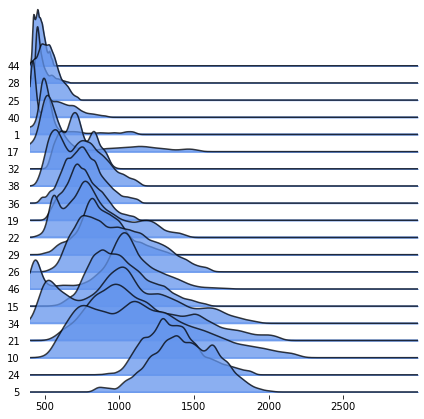

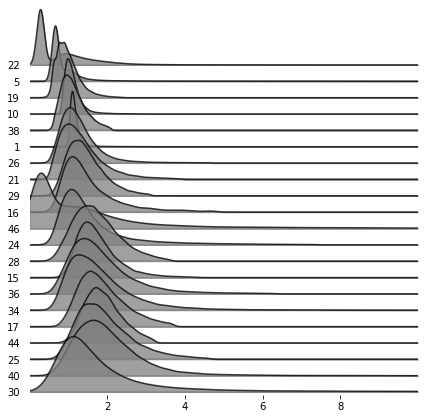

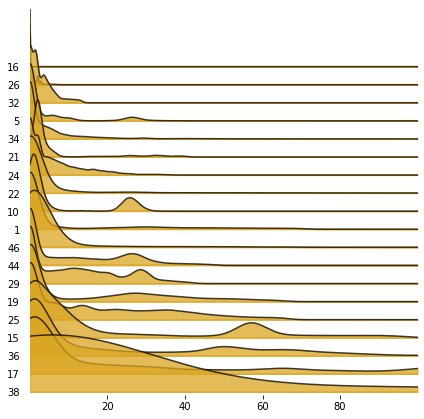

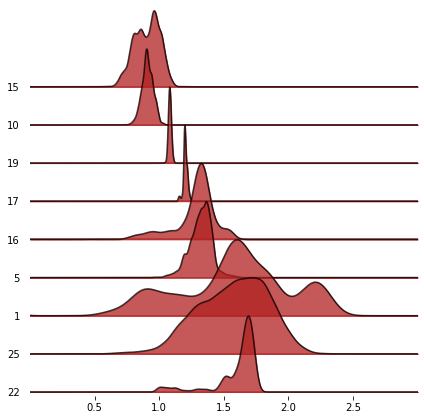

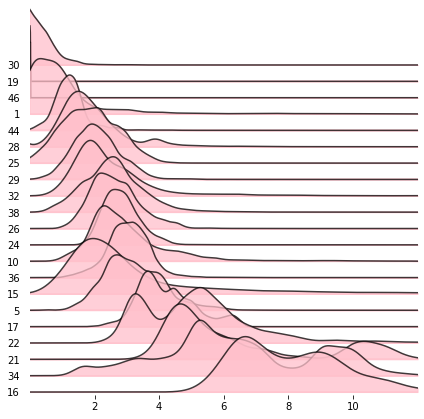

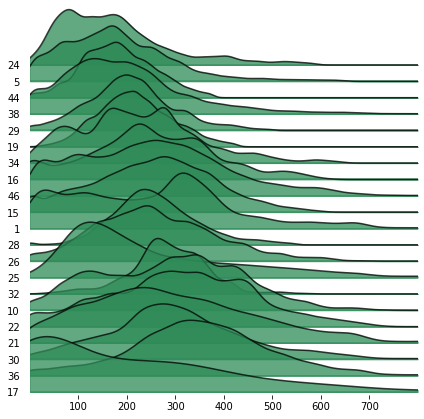

In [23]:
temp = plot_beacon_joyplots_by_stat(beacon_data,by_stat="mean",save=True,figure_note="all")

In [24]:
def plot_beacon_boxplots_by_stat(df,by_var='beacon',by_stat="mean",save=False,study_suffix="ux_s20",figure_note=""):
    '''
    Plots joyplots for the major sensors on the beacon. 
    
    Input:
    - df: DataFrame with data columns of data to plot
    - by_var: string of column used to separate the individual distributions by
    - by_stat: summary stat to order joyplots by
    
    Returns void
    '''
    variables = ['co2','pm2p5_mass','lux','no2','co','tvoc']
    units = ["Carbon Dioxide (ppm)","PM2.5 ($\mu$g/m$^3$)","Light Level (lux)","Nitrogen Dioxide (ppb)","Carbon Monoxide (ppm)"," TVOC (ppb)"]
    titles = ["a","b","c","d","e","f"]
    colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen']
    limits = [[400,3000],[0,10],[0,100],[0,3],[0,12],[0,800]]
    
    for var, color, limit, unit, title in zip(variables, colors, limits, units, titles):
        df_filtered = pd.DataFrame()
        for bb in df[by_var].unique():
            temp = df[df[by_var] == bb]
            temp['stat'] = temp[var].median() + 0.0001*int(bb)

            if len(temp) > 0:
                df_filtered = df_filtered.append(temp)
                
        fig, ax = plt.subplots(figsize=(20,8))
        df_filtered.sort_values("stat",inplace=True,ascending=False)
        sns.stripplot(x="stat",y=var,order=df_filtered["stat"].unique(),data=df_filtered)
        ax.set_xticklabels(df_filtered["beacon"].unique(),fontsize=14)
        ax.set_xlabel("")
        plt.yticks(fontsize=14)
        ax.set_ylabel(unit,fontsize=16)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        if save == True:
            plt.savefig(f'../reports/figures/beacon_summary/beacon-{var}-joyplot{figure_note}-{study_suffix}.pdf',bbox_inches="tight")
        plt.show()
        plt.close()

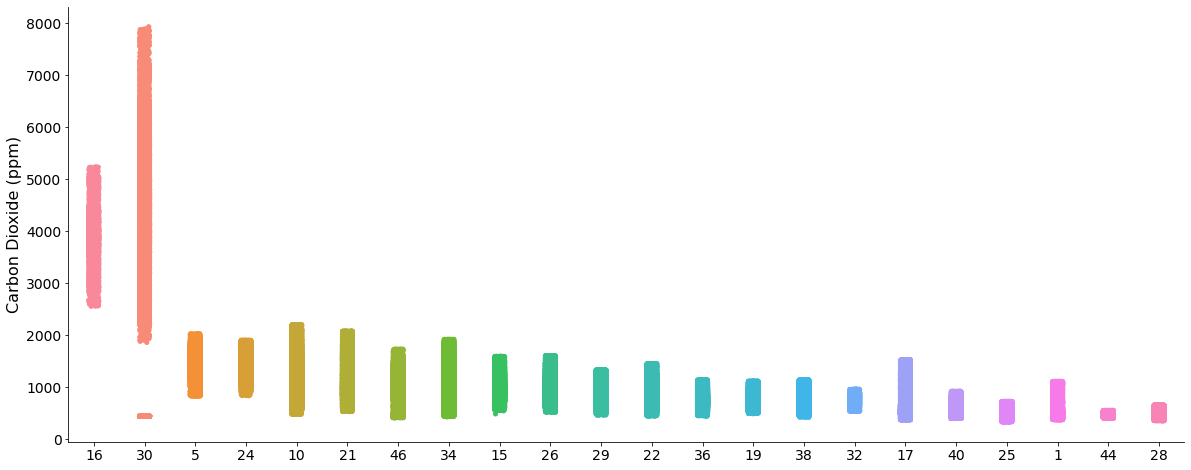

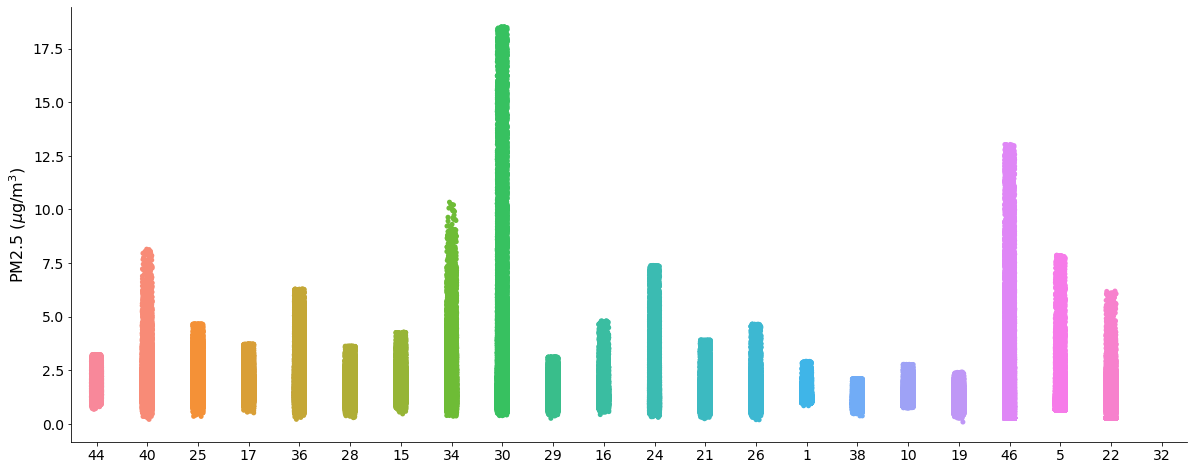

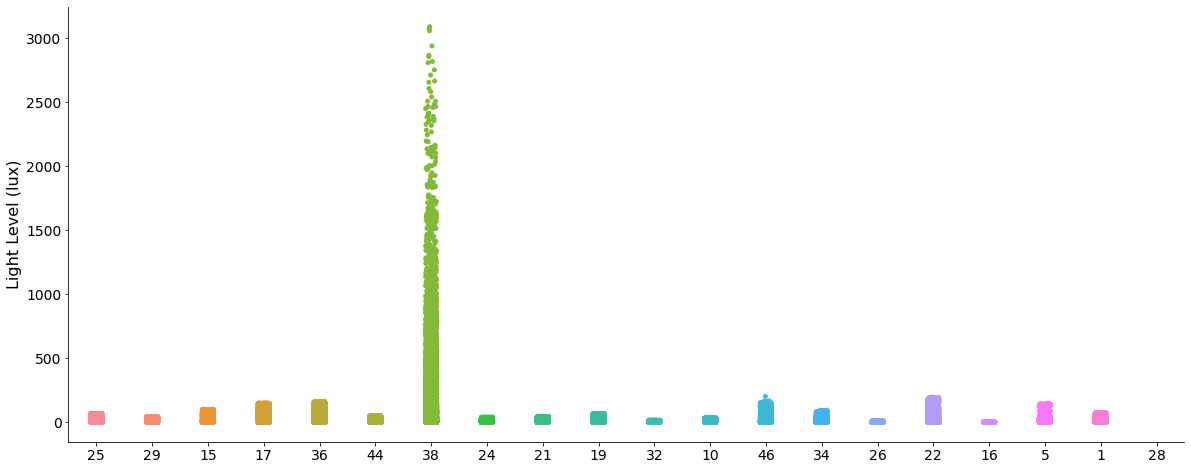

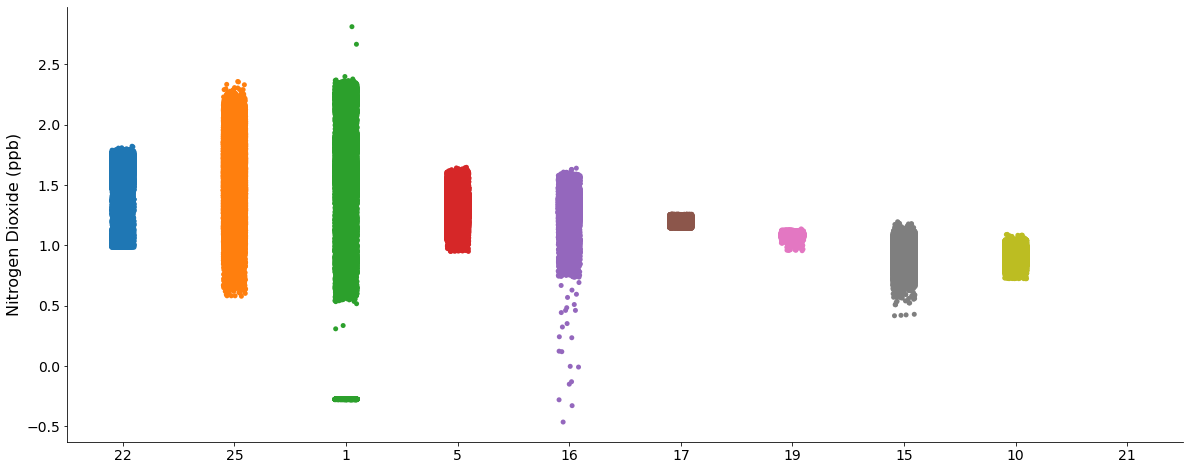

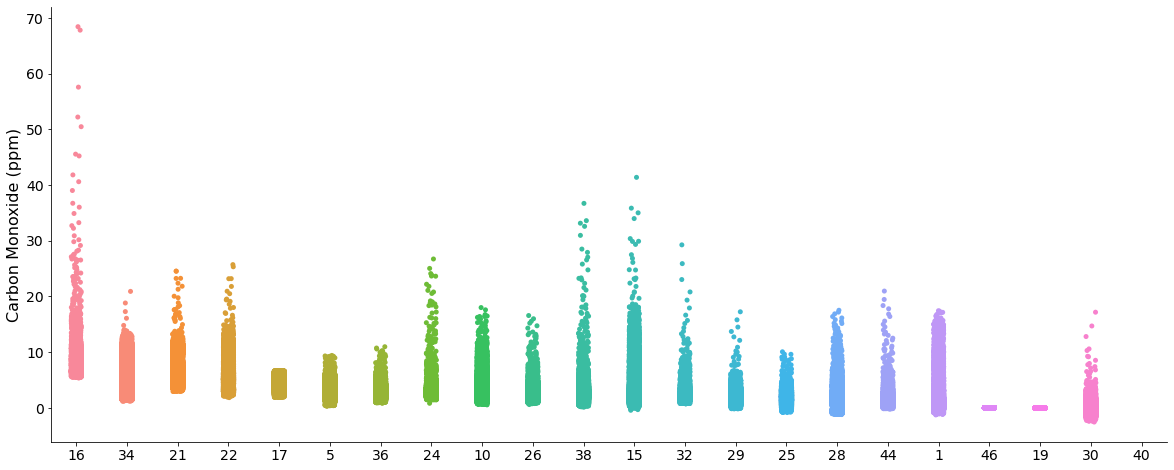

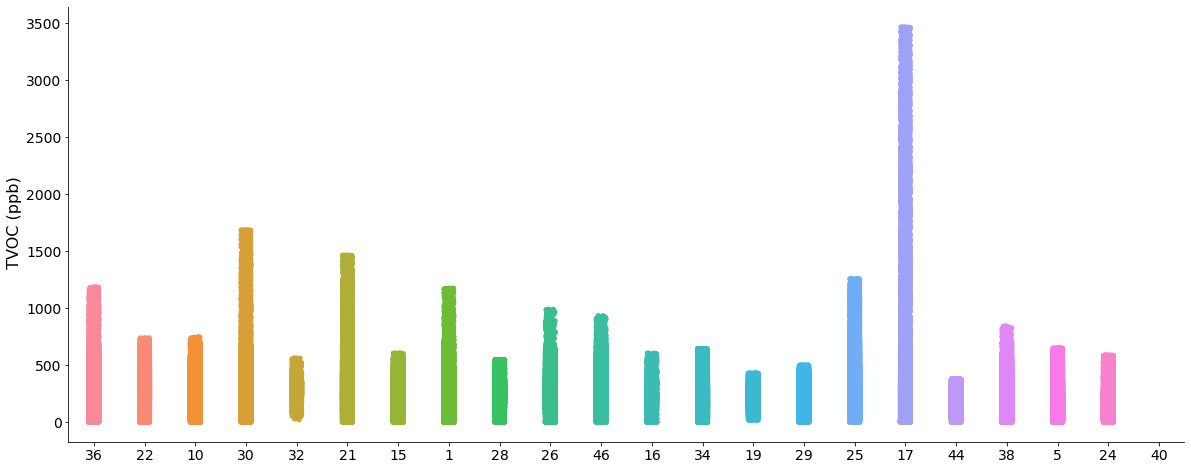

In [25]:
plot_beacon_boxplots_by_stat(beacon_data)

### Correlation Matrix

In [26]:
def plot_correlation_matrix(df,save=False,study_suffix="ux_s20"):
    """
    Plots correlation matrix between all variables in the df
    
    Inputs:
    - df: dataframe with columns named for the varaiables
    
    """
    corr = df.corr()
    corr = round(corr,2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, mask=mask, 
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,annot=True,ax=ax)

    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right')

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=-30,ha='left')

    if save:
        plt.savefig(f'../reports/figures/beacon-correlation_matrix-{study_suffix}.pdf')
        
    plt.show()
    plt.close()

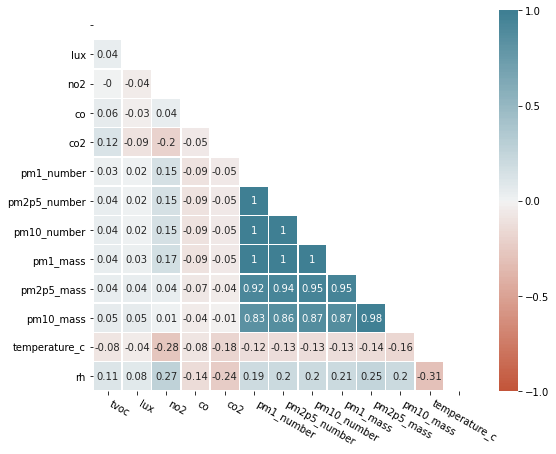

In [27]:
df_to_plot = beacon_data.drop(["beacon","fitbit","redcap"],axis=1)
plot_correlation_matrix(df_to_plot,save=True)

# Filtered Data Summary
Borrowing from other research, we can create a table of values for each of the variables measured by the beacon.

## IAQ and Sleep Overlap
We can create some figures to highlight the overlap between sleep events and measured IEQ parameters.

In [28]:
fb = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["start_time","end_time","date"],infer_datetime_format=True)
fb.head()

,duration_ms,efficiency,end_time,main_sleep,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,start_time,time_in_bed,date,beiwe,redcap,beacon,sol,wol
0,24360000,93.349754,2020-05-14 07:13:00,True,0,379,27,0,2020-05-14 00:27:00,406,2020-05-14,hfttkth7,NaN,NaN,8.5,0.0
1,29580000,79.513185,2020-05-15 08:06:30,True,8,392,101,0,2020-05-14 23:53:30,493,2020-05-15,hfttkth7,NaN,NaN,0.0,32.5
2,19740000,87.234043,2020-05-16 04:57:00,True,7,287,42,0,2020-05-15 23:28:00,329,2020-05-16,hfttkth7,NaN,NaN,11.5,11.0
3,26820000,90.156600,2020-05-17 09:28:30,True,8,403,44,0,2020-05-17 02:01:30,447,2020-05-17,hfttkth7,NaN,NaN,12.5,8.5
4,24960000,84.375000,2020-05-18 07:20:00,True,0,351,65,0,2020-05-18 00:24:00,416,2020-05-18,hfttkth7,NaN,NaN,11.5,0.0


In [29]:
def check_for_null(row,subset=None):
    """Checks to see if value is null in subset of columns within a row"""
    if row.count() > 0:
        return 1
    else:
        return 0

In [30]:
def plot_ieq_sleep_overlap(beacon_data,sleep_data,pid,ieq_params=["tvoc","co","co2","pm2p5_mass","temperature_c"],save=False):
    """"""
    fig, ax = plt.subplots(figsize=(16,4))
    # Plotting beacon data
    b_df = beacon_data.copy()
    b_df["operation"] = b_df.apply(lambda row: check_for_null(row[ieq_params]),axis="columns")
    scat = ax.scatter(b_df.index,b_df["operation"],color="black",s=5)
    # Plotting fitbit data
    for s, e in zip(pd.to_datetime(sleep_data["start_time"]),pd.to_datetime(sleep_data["end_time"])):
        sleep = ax.axvspan(s,e,color="seagreen",alpha=0.25,zorder=1)
        
    # Formatting figure
    ## x-axis
    ax.set_xlim([datetime(2020,6,15),datetime(2020,9,1)])
    plt.xticks(fontsize=14)
    ## y-axis
    ax.set_ylim([-0.5,1.5])
    ax.set_yticks([0,1])
    ax.set_yticklabels(["OFF","ON"],fontsize=14)
    ax.set_ylabel("")
    ## Remainder
    ax.legend([scat,sleep],["Beacon Operation","Fitbit Sleep Event"],loc="center",bbox_to_anchor=(0.5,-0.15),fontsize=12,ncol=2,frameon=False)
    ax.set_title(f"Participant ID: {pid}",fontsize=14)
    if save:
        plt.savefig(f"../reports/figures/beacon_fitbit/ieq_sleep_overlap-{pid}-ux_s20.png")
    plt.show()
    plt.close()
    

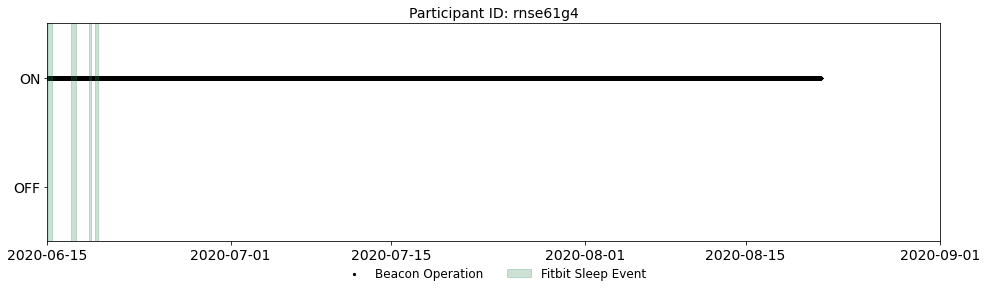

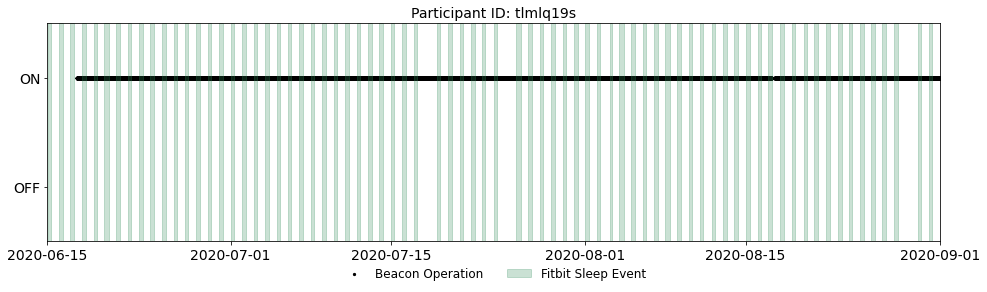

In [31]:
for bid in beacon_data["beiwe"].unique():
    if bid in ["tlmlq19s","rnse61g4"]:
        beacon_by_pt = beacon_data[beacon_data["beiwe"] == bid]
        fb_by_pt = fb[fb["beiwe"] == bid]
        if len(beacon_by_pt) > 0 and len(fb_by_pt) > 0:
            plot_ieq_sleep_overlap(beacon_by_pt,fb_by_pt,bid,save=True)

## Filtered by Fitbit and GPS
These data are those for nights when Fitbit detects sleep and the person is home.

In [56]:
beacon_fitbit = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                             index_col=0)
beacon_fitbit.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,184.700000,2.04,NaN,10.742600,1816.486399,0.145358,...,1.831140,1.901793,24.0,33.183333,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,164.000000,2.04,NaN,10.678200,1795.248136,0.178794,...,1.878851,1.919541,24.0,33.000000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,152.433333,2.04,NaN,10.676133,1763.231375,0.186363,...,1.652677,1.861326,24.0,33.000000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,159.150000,2.04,NaN,10.703900,1724.723961,NaN,...,1.497815,1.833923,24.0,33.050000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,143.933333,2.04,NaN,10.667433,1772.028385,1.646941,...,2.056448,1.964887,24.0,32.983333,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30


Removing unecessary columns

In [57]:
variables = ['temperature_c','rh','tvoc','co2','co','no2','pm2p5_mass']
beacon_fitbit_important = beacon_fitbit[variables]
beacon_fitbit_important.columns

Index(['temperature_c', 'rh', 'tvoc', 'co2', 'co', 'no2', 'pm2p5_mass'], dtype='object')

### Summary Statistics

In [65]:
stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'max':[]}
precision = 1
for variable in variables:
    li = beacon_fitbit_important[variable].dropna().values
    stats['n'].append(len(li))
    stats['avg'].append(round(np.nanmean(li),precision))
    stats['med'].append(round(np.nanmedian(li),precision))
    stats['min'].append(round(np.nanmin(li),precision))
    stats['25%'].append(round(np.nanpercentile(li,25),precision))
    stats['75%'].append(round(np.nanpercentile(li,75),precision))
    stats['max'].append(round(np.nanmax(li),precision))

Looking at those stats

In [66]:
stats_df = pd.DataFrame(data=stats)
stats_df.index = variables
stats_df.to_csv('/Users/hagenfritz/Desktop/partially_filtered_summary.csv')
stats_df

,n,avg,med,min,25%,75%,max
temperature_c,24640,27.1,27.2,22.0,25.4,28.5,33.0
rh,24951,42.8,42.0,27.5,39.5,45.8,63.0
tvoc,24754,260.8,241.4,0.0,184.5,320.7,3270.7
co2,23876,964.3,880.0,390.7,741.4,1099.0,5234.8
co,21732,2.9,2.6,0.0,1.6,3.5,18.1
no2,11354,1.2,1.1,0.3,1.0,1.2,2.1
pm2p5_mass,23587,4.0,3.0,0.1,1.9,4.7,95.6


### Summary per Participant

In [91]:
nightly_mean_partial = beacon_fitbit.groupby(["beiwe","beacon"]).agg(["mean","count"])
var = "no2"
nightly_mean_partial[var].sort_values("mean")

,,mean,count
beiwe,beacon,,
9jtzsuu8,15,0.868877,2030
xlw5ntd5,10,0.901829,907
qh34m4r9,19,1.085940,4559
9xmhtq74,17,1.204449,644
745vq78e,5,1.317493,922
e73a1pd5,16,1.323271,206
vr9j5rry,25,1.546278,965
kyj367pi,1,1.647700,1121
4i7679py,44,NaN,0


In [68]:
beacon_fitbit.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,184.700000,2.04,NaN,10.742600,1816.486399,0.145358,...,1.831140,1.901793,24.0,33.183333,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,164.000000,2.04,NaN,10.678200,1795.248136,0.178794,...,1.878851,1.919541,24.0,33.000000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,152.433333,2.04,NaN,10.676133,1763.231375,0.186363,...,1.652677,1.861326,24.0,33.000000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,159.150000,2.04,NaN,10.703900,1724.723961,NaN,...,1.497815,1.833923,24.0,33.050000,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,143.933333,2.04,NaN,10.667433,1772.028385,1.646941,...,2.056448,1.964887,24.0,32.983333,21,lkkjddam,25.0,12,2020-08-10 04:42:30,2020-08-10 12:35:30


### Correlation matrix between the "important" variables

In [60]:
def plot_correlation_matrix_filtered(df,name="partially_filtered",save=False):
    df.columns = ['TVOC','Light','NO$_2$','CO','T','RH','CO$_2$','PM$_{2.5}$']
    corr = df.corr()
    corr = round(corr,2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, mask=mask, 
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,annot=True,ax=ax)

    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right')

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=0,ha='center')
    if save:
        plt.savefig(f'../reports/figures/beacon_{name}-correlation_matrix-ux_s20.pdf')
    plt.show()
    plt.close()

In [61]:
plot_correlation_matrix_filtered(beacon_fitbit_important,save=True)

ValueError: Length mismatch: Expected axis has 7 elements, new values have 8 elements

### Summary Figures
Visualizing the partially filtered Beacon data.

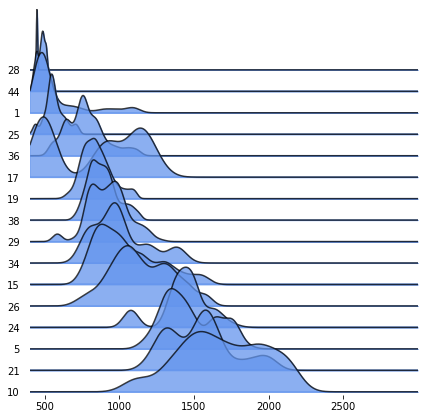

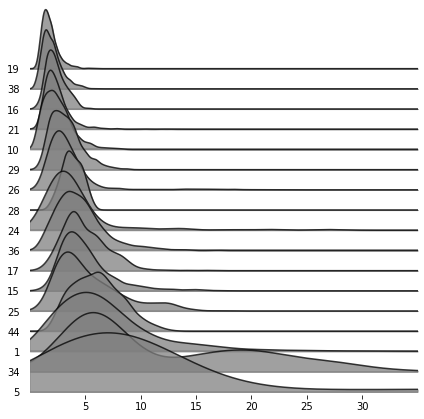

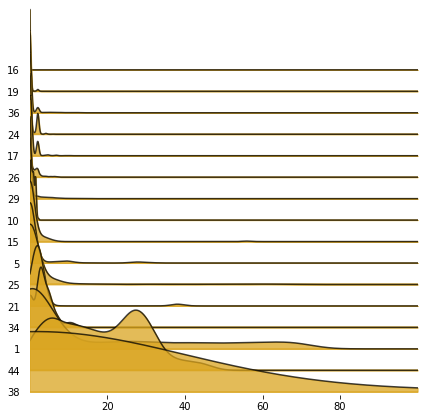

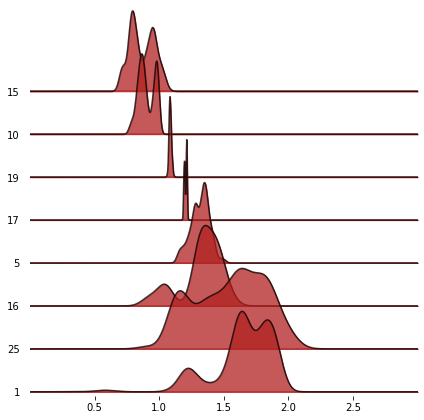

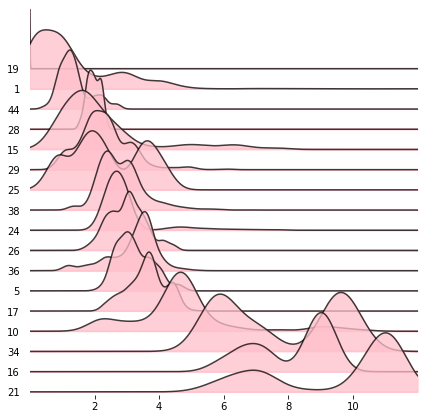

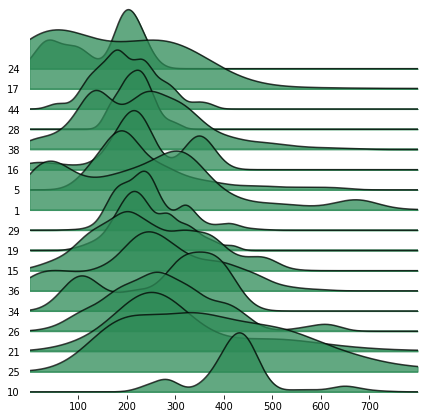

In [64]:
temp = plot_beacon_joyplots_by_stat(beacon_fitbit, save=True, figure_note="_partially_filtered")

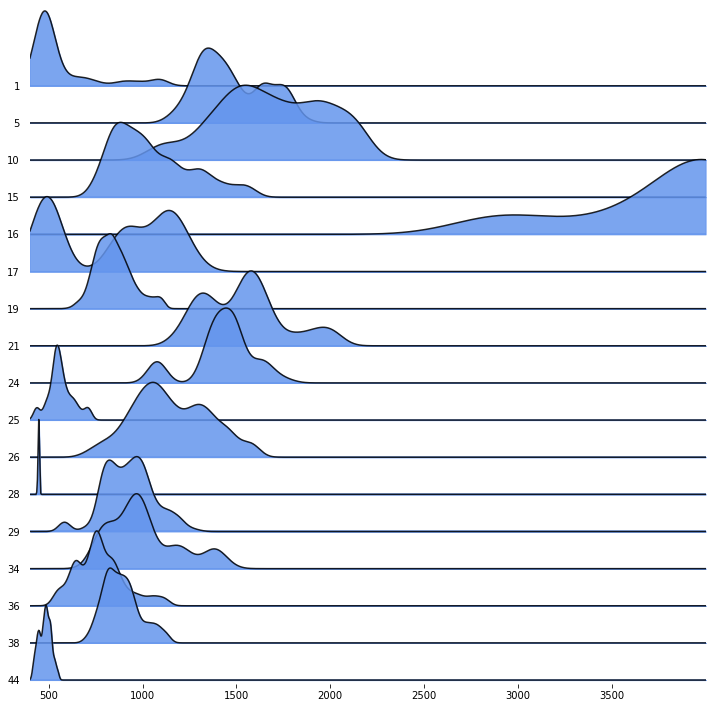

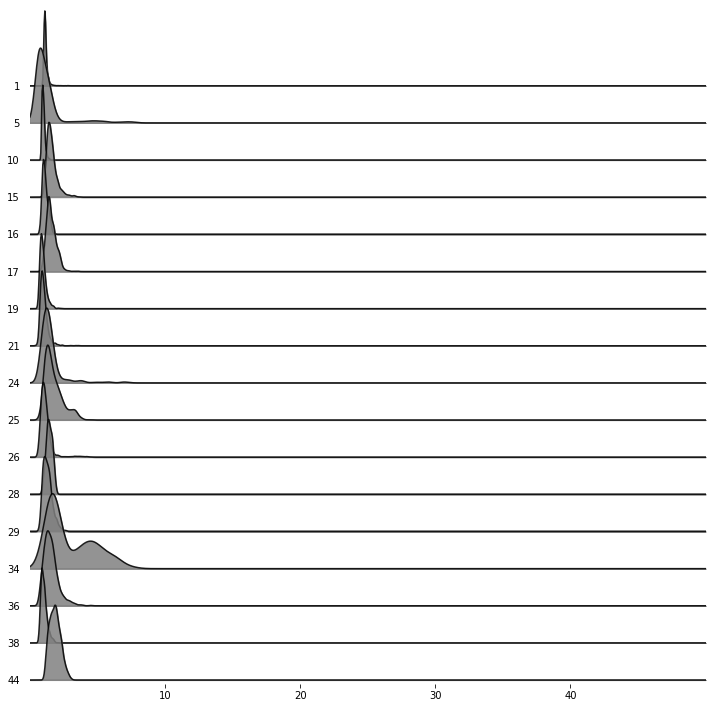

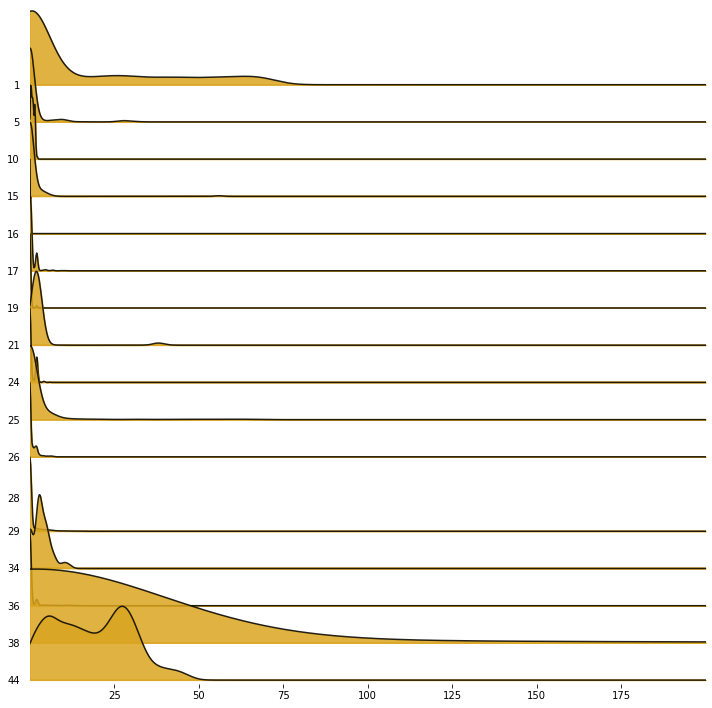

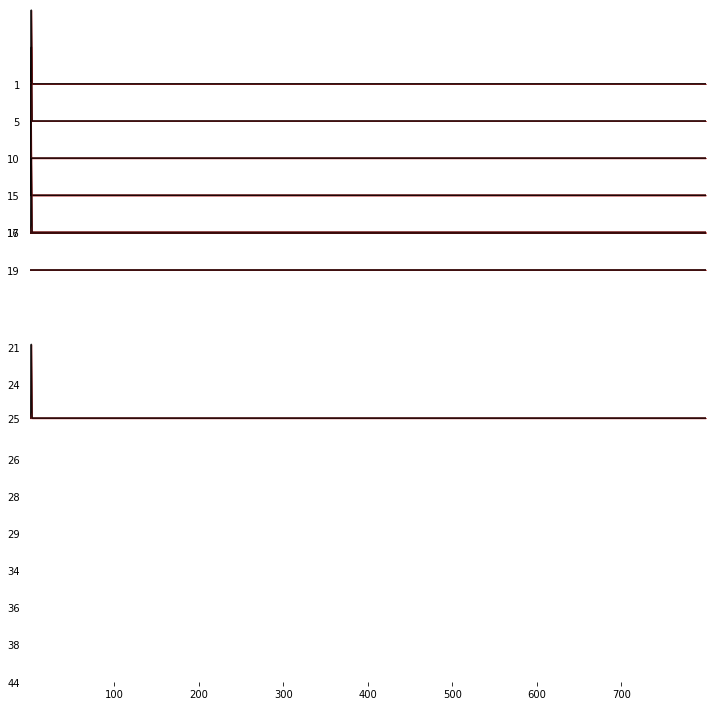

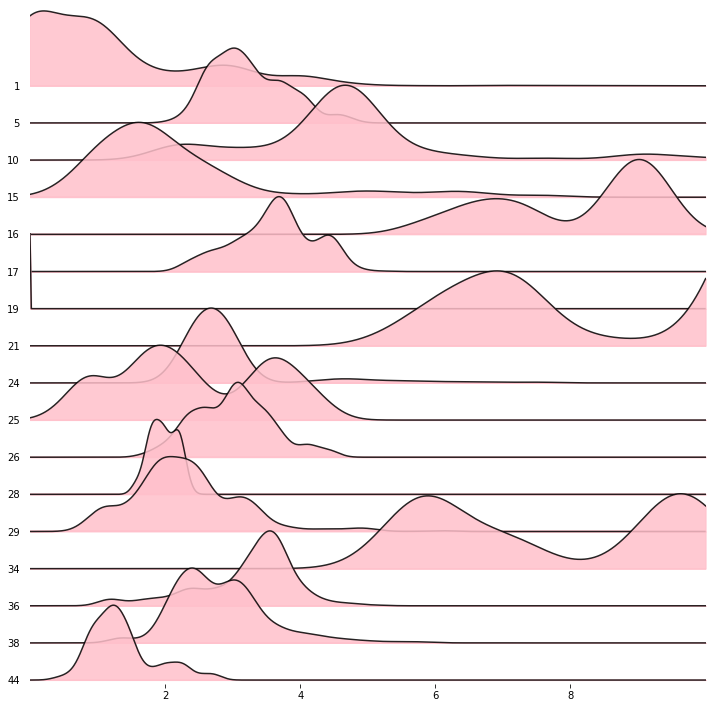

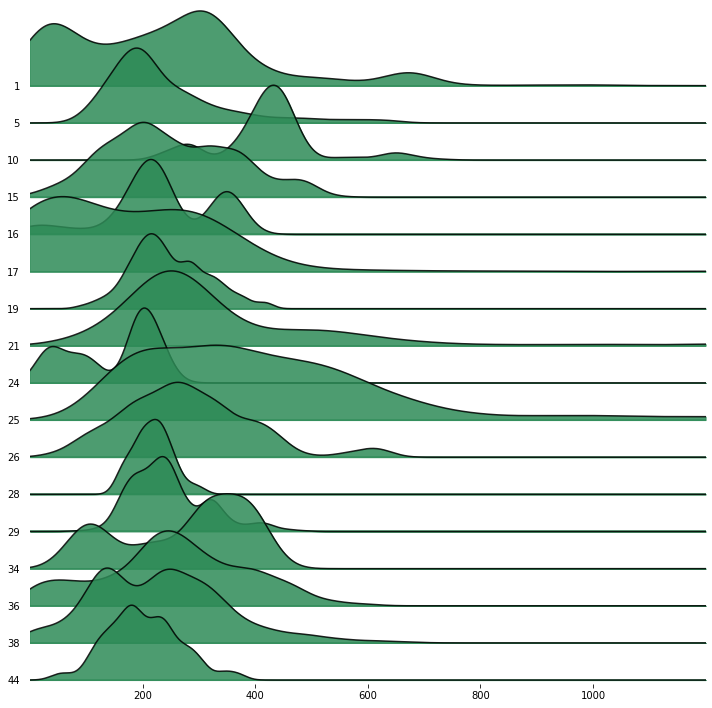

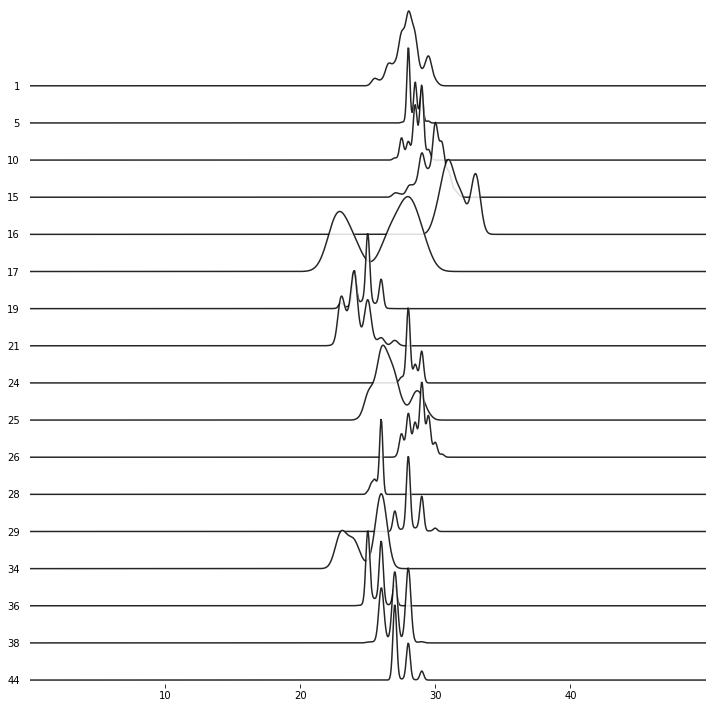

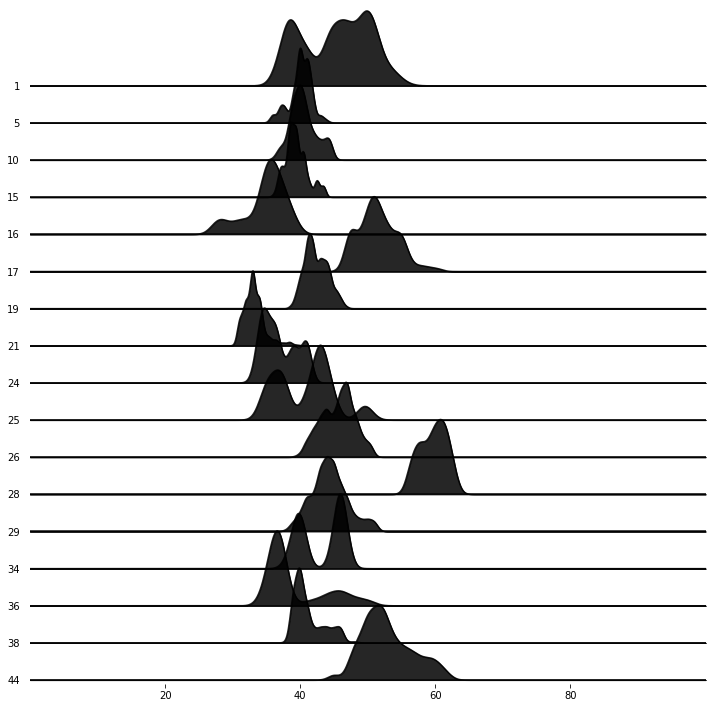

In [39]:
plot_beacon_joyplots_by_number(beacon_fitbit, variables=['co2','pm2p5_mass','lux','no2','co','tvoc','temperature_c','rh'],
                     colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen','white','black'],
                     limits = [[400,4000],[0,50],[0,200],[0,800],[0,10],[0,1200],[0,50],[0,100]], by_var='beacon')


## Filtered by EMA and Fitbit

In [42]:
beacon_filtered = pd.read_csv('../data/processed/beacon-fb_ema_and_gps_filtered-ux_s20.csv',
                             index_col=0)
beacon_filtered.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,184.700000,2.04,NaN,10.742600,1816.486399,0.145358,...,0.891251,1.901793,24.0,33.183333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,164.000000,2.04,NaN,10.678200,1795.248136,0.178794,...,0.903066,1.919541,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,152.433333,2.04,NaN,10.676133,1763.231375,0.186363,...,0.847057,1.861326,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,159.150000,2.04,NaN,10.703900,1724.723961,NaN,...,0.808707,1.833923,24.0,33.050000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,143.933333,2.04,NaN,10.667433,1772.028385,1.646941,...,0.947046,1.964887,24.0,32.983333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


Checking to see what the minimum CO2 value over 400 ppm is (for cleaning purposes in the ```make_dataset.py``` source code).

In [43]:
np.nanmin(beacon_filtered[beacon_filtered['co2'] > 400]['co2'])

400.7194784838873

Dropping all unecessary columns

In [44]:
variables = ['temperature_c','rh','tvoc','co2','co','no2','pm2p5_mass']
beacon_important = beacon_filtered[variables]
beacon_important.columns

Index(['temperature_c', 'rh', 'tvoc', 'co2', 'co', 'no2', 'pm2p5_mass'], dtype='object')

Getting descriptive stats

In [45]:
stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'max':[]}
precision = 1
for variable in variables:
    li = beacon_filtered[variable].dropna().values
    stats['n'].append(len(li))
    stats['avg'].append(round(np.nanmean(li),precision))
    stats['med'].append(round(np.nanmedian(li),precision))
    stats['min'].append(round(np.nanmin(li),precision))
    stats['25%'].append(round(np.nanpercentile(li,25),precision))
    stats['75%'].append(round(np.nanpercentile(li,75),precision))
    stats['max'].append(round(np.nanmax(li),precision))

Creating a stats dataframe and outputting the results

In [46]:
stats_df = pd.DataFrame(data=stats)
stats_df.index = variables
stats_df.to_csv('/Users/hagenfritz/Desktop/fully_filtered_summary.csv')
stats_df

,n,avg,med,min,25%,75%,max
temperature_c,14712,27.1,27.5,22.2,25.5,28.5,31.6
rh,14766,42.7,42.0,30.8,39.2,45.7,63.0
tvoc,14766,262.9,245.0,0.0,183.1,332.1,1462.7
co2,14244,946.0,884.8,390.7,748.0,1116.7,2207.4
co,14886,2.5,2.4,-0.3,1.0,3.4,16.8
no2,7029,1.1,1.1,-0.3,1.0,1.2,2.1
pm2p5_mass,14316,1.3,1.2,0.5,1.0,1.5,7.6


Creating a correlation matrix

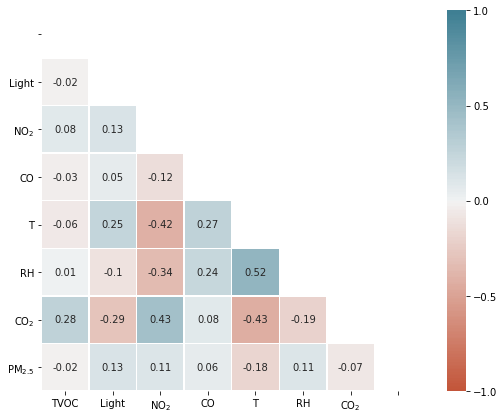

In [44]:
plot_correlation_matrix_filtered(beacon_important,name="fully_filtered",save=False)

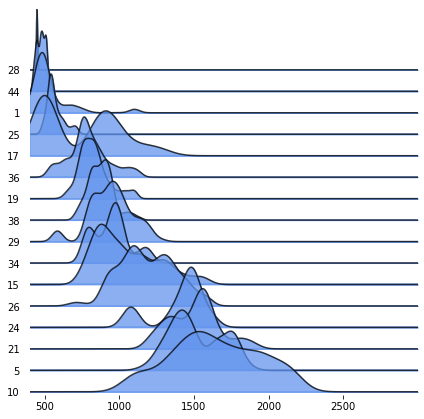

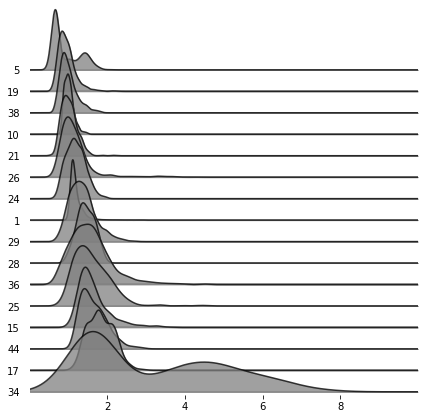

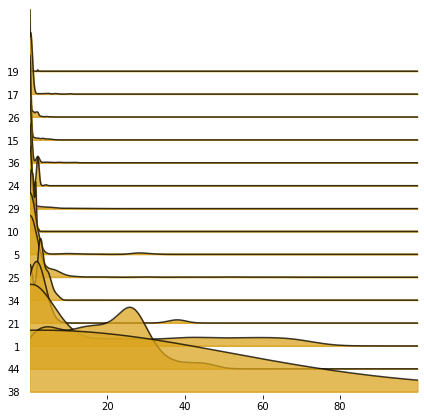

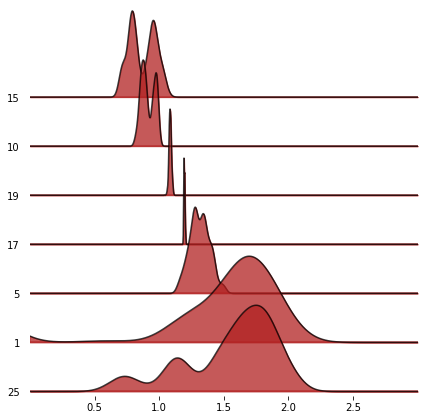

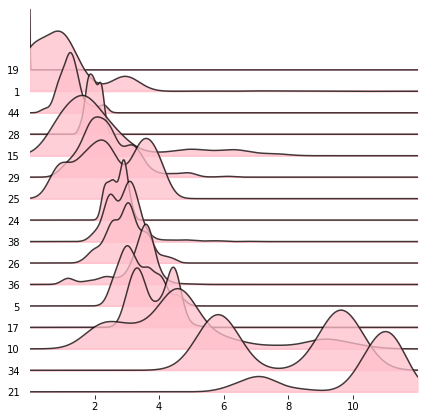

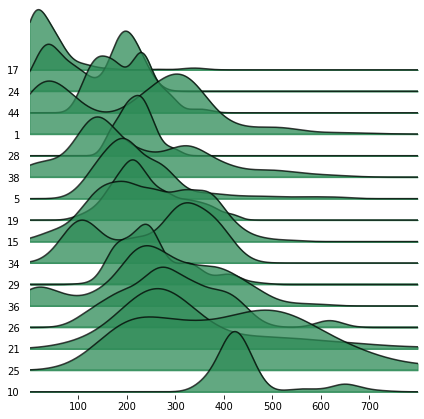

In [45]:
temp = plot_beacon_joyplots_by_stat(beacon_filtered, save=True, figure_note="_fully_filtered")

# Combined Datasets
Looking at the partially and fully filtered datasets

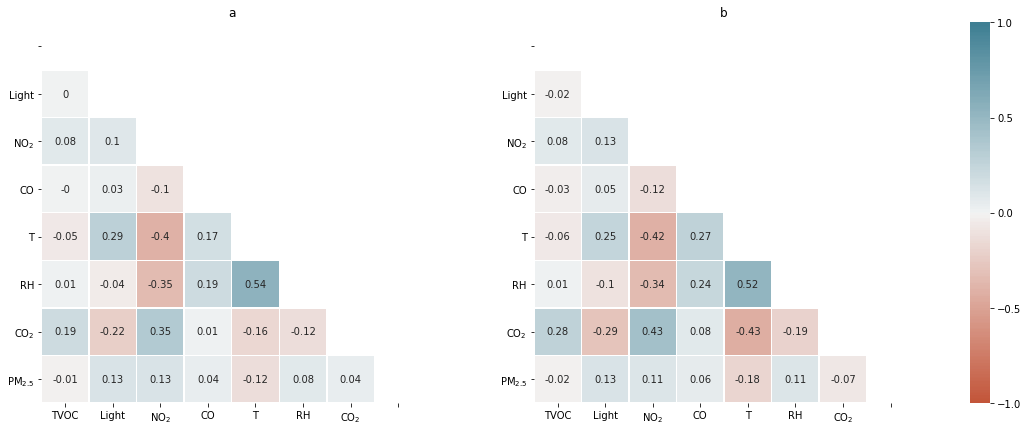

In [46]:
fig, axes = plt.subplots(1,3,figsize=(18, 7),gridspec_kw={'width_ratios': [25,25,1],"wspace":0})
for i, df in zip(range(2),[beacon_fitbit_important,beacon_important]):
    ax = axes[i]
    df.columns = ['TVOC','Light','NO$_2$','CO','T','RH','CO$_2$','PM$_{2.5}$']
    corr = df.corr()
    corr = round(corr,2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    if i == 0:
        sns.heatmap(corr, mask=mask, 
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,annot=True,cbar=False,ax=ax)
        ax.set_title("a")
    else:
        sns.heatmap(corr, mask=mask, 
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,annot=True,cbar_ax=axes[-1],ax=ax)
        ax.set_title("b")

    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right')

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=0,ha='center')
    
plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-correlation_matrix_combined-ux_s20.pdf',bbox_inches="tight")
plt.show()
plt.close()

# Filtered Data Completeness
We can also look at how complete the datasets are. There are two ways to summarize the completeness:
1. Percent of possible data collected over the study period i.e. while the participants had their respective devices
2. Percent of possible data collected while the beacon was actually operating. 
3. Percent of possible data collected when participants are home and asleep.
4. Percent of possible data collected when participants are home, asleep, and answered the survey the following morning. 


## Percent of Possible Data During Study Period
We first need to ensure that we have the correct start and stop periods for each individual. This information is housed in the ```details``` dataframe. 

We want to cross-reference the arrival date of the beacon to the individual and assume that is the start date. The end date can be changed to correspond to Sept. 1st or the return date - whatever happened first.  

In [47]:
overall_op = {}

### Number of Possible Nights
Another, related metric, is how many nights out of the possible we recorded data for each individual. We can use the same loop to determine the maximum number of nights.

In [48]:
variables = ['beacon','lux','tvoc','co2','co','no2','pm2p5_mass']
beacon_df = beacon_data[variables].sort_index()[:datetime(2020,9,1)]

max_n = 0
max_n_no2 = 0
no2_beacons = []
n_nights_max = 0
for bb in beacon_df['beacon'].unique():
    if bb not in [22,26,46]: # beacons with no Fitbit data or GPS data
        beacon_pt = beacon_df[beacon_df['beacon'] == bb]
        starting_date = pd.to_datetime(details[details['beacon'] == bb]['start_date'].values[0])
        ending_date = pd.to_datetime(details[details['beacon'] == bb]['end_date'].values[0])
        if ending_date > datetime(2020,9,1):
            ending_date = datetime(2020,9,1)

        max_n += (ending_date - starting_date).total_seconds()/60/5
        n_nights_max += (ending_date.date() - starting_date.date()).days
        # Add no2 count
        if details[details['beacon'] == bb]['no2_sensor'].values[0] == 'Yes':
            max_n_no2 += (ending_date - starting_date).total_seconds()/60/5
            no2_beacons.append(bb)
        else:
            print(f'{bb}: no NO2 data')
        
print(f'Number of Beacons with NO2 Sensors: {len(no2_beacons)}')

29: no NO2 data
30: no NO2 data
34: no NO2 data
38: no NO2 data
36: no NO2 data
32: no NO2 data
40: no NO2 data
44: no NO2 data
28: no NO2 data
Number of Beacons with NO2 Sensors: 10


Now that we have the max number of data points possible, we can divide the number of actual measurments by the count. We have to take special consideration for the NO2 sensor though since not all devices had one. 

In [49]:
op_period_df = pd.DataFrame()
op_period_df['n'] = beacon_df.count()
op_period_df['max_n'] = max_n
op_period_df['percent'] = beacon_df.count()/max_n
op_period_df.loc['no2','max_n'] = max_n_no2
op_period_df.loc['no2','percent'] = op_period_df.loc['no2','n'] / max_n_no2
op_period_df.drop('beacon',inplace=True)
op_period_df

,n,max_n,percent
lux,765573,397927.6,1.923900
tvoc,892387,397927.6,2.242586
co2,910214,397927.6,2.287386
co,905388,397927.6,2.275258
no2,361862,224472.6,1.612054
pm2p5_mass,890471,397927.6,2.237771


In [50]:
total_n = op_period_df['n'].sum()
total_max_n = op_period_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 2.1344439613811517


Adding to overall operation

In [51]:
overall_op['During Study'] = list(np.around(op_period_df['percent'].values*100,1))
overall_op['During Study'].append(round(total_n/total_max_n*100,1))

Also with the max number of nights, we can look at the unique ending times of a person's sleep schedule to to get an idea of how many nights we did record.

In [52]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1392


## Percent of Possible Data while Operating
Now we look at when the beacon is powered on and see how much data was gathered

In [53]:
temp = beacon_df.drop(['beacon'],axis=1).dropna(how='all')
op_df = pd.DataFrame()
op_df['n'] = temp.count()
op_df['max_n'] = len(temp)
op_df['percent'] = temp.count()/len(temp)

Have to change up the approach for the NO2 sensor and only consider beacons with the sensor for ```max_n```

In [54]:
# dataframe with only beacons with NO2 sensors and removing times when all sensors measured nothing
no2_temp = beacon_df[beacon_df['beacon'].isin(no2_beacons)].drop(['beacon'],axis=1).dropna(how='all')
op_df.loc['no2','max_n'] = len(no2_temp)
op_df.loc['no2','percent'] = op_df.loc['no2','n'] / len(no2_temp)
op_df


,n,max_n,percent
lux,765573,936585,0.817409
tvoc,892387,936585,0.952809
co2,910214,936585,0.971843
co,905388,936585,0.966691
no2,361862,441158,0.820255
pm2p5_mass,890471,936585,0.950764


In [55]:
total_n = op_df['n'].sum()
total_max_n = op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9222908762406854


Adding to overall op

In [56]:
overall_op['While Operating'] = list(np.around(op_df['percent'].values*100,1))
overall_op['While Operating'].append(round(total_n/total_max_n*100,1))

The number of nights recorded will be the same reported above:

In [57]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1392


## Percent of Possible Data while Asleep and At Homes
Now we look at an even smaller window of the nightly measured values - filtered by GPS and Fitbit

In [58]:
beacon_fitbit_important = beacon_fitbit[variables]
temp = beacon_fitbit_important.drop(['beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

Considering NO2 only now

In [60]:
no2_temp = beacon_fitbit_important[beacon_fitbit_important['beacon'].isin(no2_beacons)].dropna(how='all')
no2_temp.drop(['beacon'],axis=1,inplace=True)
night_op_df.loc['no2','max_n'] = len(no2_temp)
night_op_df.loc['no2','percent'] = night_op_df.loc['no2','n'] / len(no2_temp)
night_op_df

,n,max_n,percent
lux,24002,25103,0.956141
tvoc,24754,25103,0.986097
co2,23876,25103,0.951121
co,25091,25103,0.999522
no2,11798,13330,0.885071
pm2p5_mass,24001,25103,0.956101


In [61]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9616622852821491


Adding to overall operation

In [62]:
overall_op['Asleep and Home'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep and Home'].append(round(total_n/total_max_n*100,1))

### Number of nights recorded under this scheme

#### Aggregate
Number of nights measured considering all participants

In [63]:
df = beacon_fitbit.groupby(['start_time']).mean()
df = df[variables]
df.drop('beacon',axis=1,inplace=True)
print('Total Number of Nights Measured:',len(df.dropna(how='all')))

Total Number of Nights Measured: 332


Aggregate number of nights per sensor and how many sensors contributed to these nights.

In [64]:
vars_to_check = ['lux','tvoc','co2','co','no2','pm2p5_mass']

for variable in vars_to_check:
    sensor_df = beacon_fitbit[[variable,'start_time','beacon']]
    sensor_df.dropna(inplace=True)
    print(f'Number of Nights for {variable}:',len(sensor_df['start_time'].unique()))
    print(f'Number of Beacons:', len(sensor_df['beacon'].unique()))

Number of Nights for lux: 330
Number of Beacons: 16
Number of Nights for tvoc: 331
Number of Beacons: 17
Number of Nights for co2: 332
Number of Beacons: 17
Number of Nights for co: 332
Number of Beacons: 17
Number of Nights for no2: 139
Number of Beacons: 8
Number of Nights for pm2p5_mass: 318
Number of Beacons: 17


Visual inspection to see when some of the sensors are operating

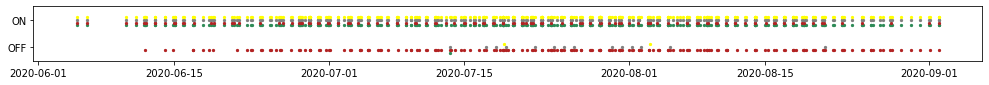

In [65]:
fig, ax = plt.subplots(figsize=(17,1))
colors = ['seagreen','firebrick','grey','yellow']
jitter = -0.2
for variable, c in zip(['tvoc','no2','pm2p5_mass','lux'],colors):
    temp = df[df[variable] > -1000]
    temp['values'] = np.ones(len(temp))
    temp.index = pd.to_datetime(temp.index)
    bad = df[np.isnan(df[variable])]
    bad['values'] = np.zeros(len(bad))
    bad.index = pd.to_datetime(bad.index)
    ax.scatter(temp.index,temp['values']+jitter,color=c,s=5)
    ax.scatter(bad.index,bad['values']+jitter,color=c,s=5)
    jitter += 0.1

ax.set_ylim([-0.5,1.5])
ax.set_yticks([0,1])
ax.set_yticklabels(['OFF','ON'])
plt.show()
plt.close()

#### Per Participant
Now we see how many nights were recorded for each beacon.

In [66]:
def plot_data_availability_by_beacon(df):
    '''
    Plots a stripplot plot of the number of nights each beacon was operating for by sensor
    
    Inputs:
    - df: dataframe with columns in columns_to_use
    
    Returns void
    '''
    columns_to_use = ['lux','tvoc','co2','co','no2','pm1_mass','pm2p5_mass','pm10_mass','beacon','start_time']
    df_filtered = df[columns_to_use]
    data = {'lux':[],'tvoc':[],'co2':[],'co':[],'no2':[],'pm1_mass':[],'pm2p5_mass':[],'pm10_mass':[],'beacon':[]}
    for bb in df_filtered['beacon'].unique():
        df_by_bb = df_filtered[df_filtered['beacon'] == bb]
        df_by_bb_by_night = df_by_bb.groupby('start_time').mean()
        for var in columns_to_use:
            if var == 'start_time':
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    df_count = pd.DataFrame(data)
    df_to_plot = df_count.melt(id_vars=['beacon'],value_vars=['lux','tvoc','co2','co','no2','pm1_mass','pm2p5_mass','pm10_mass'],
                              var_name='Variable', value_name='Number of Nights')
    fig, ax = plt.subplots(figsize=(12,6))
    sns.stripplot(x='Variable',y='Number of Nights',hue='beacon',data=df_to_plot,size=7.5,jitter=0.25,ax=ax,
                 marker='o')
    
    ax.set_xticklabels(['Light','TVOC','CO$_2$','CO','NO$_2$','PM$_1$','PM$_{2.5}$','PM$_{10}$'])
    for loc in ['right','top','bottom']:
        ax.spines[loc].set_visible(False)
    
    ax.legend(bbox_to_anchor=(1.08,1),frameon=False)
        
    plt.show()
    plt.close()
    

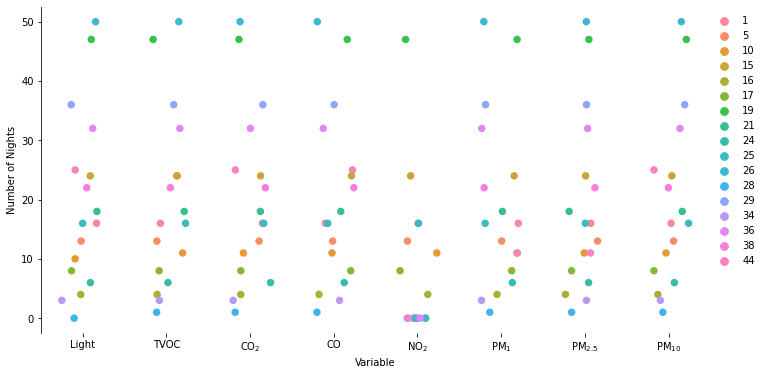

In [67]:
plot_data_availability_by_beacon(beacon_fitbit)

In [68]:
def plot_data_availability_heatmap(df, df_filter='not', save=False, save_dir='../reports/figures/'):
    '''
    Plots a heatmap showing number of nights the various beacons measured for each sensor
    
    Inputs
    - df: dataframe with columns in columns_to_use
    - df_filter: the naming convention of the filtering applied to the beacon - used when saving
    - savefig: boolean specifying whether or not to save the file
    - save_dir: string of the location to save the figure
    
    Returns the count dataframe used to generate the heatmap
    '''
    # filtering the dataframe to only include import vars
    columns_to_use = ['lux','tvoc','co2','co','no2','pm2p5_mass','beacon','start_time']
    df_filtered = df[columns_to_use]
    # dict to store the values
    data = {'lux':[],'tvoc':[],'co2':[],'co':[],'no2':[],'pm2p5_mass':[],'beacon':[]}
    # looping through the dataframe to get the number of nights each beacon measured
    for bb in df_filtered['beacon'].unique():
        df_by_bb = df_filtered[df_filtered['beacon'] == bb]
        df_by_bb_by_night = df_by_bb.groupby('start_time').mean()
        for var in columns_to_use:
            if var == 'start_time':
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    # formatting dataframe
    df_count = pd.DataFrame(data=data,index=data['beacon'])
    df_count.drop('beacon',axis=1,inplace=True)
    df_count.sort_index(inplace=True)
    
    # plotting heatmap
    fig, ax = plt.subplots(figsize=(12,5))
    sns.heatmap(df_count.sort_values(by='lux').T,square=True,annot=True,fmt="d",linewidths=.5,cmap="Blues",vmin=0,vmax=50,cbar_kws={"shrink":0.9,"pad":0.02},ax=ax)
    # reformatting figure labels
    ax.set_yticklabels(['Light','TVOC','CO$_2$','CO','NO$_2$','PM$_{2.5}$'],rotation=0)
    ax.set_xlabel('Beacon Number')
    ax.set_title('Number of Nights Measured by BEVO Beacon')
    
    # saving and showing
    if save:
        plt.savefig(f'{save_dir}beacon_{df_filter}_filtered-data_availability-heatmap-ux_s20.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    return df_count

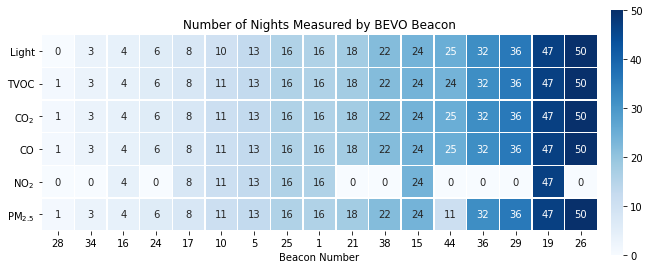

In [69]:
partially_filtered_nights = plot_data_availability_heatmap(beacon_fitbit, df_filter='partially', save=True, save_dir="../../papers/5eea5276044b790001ee5687/figures/")

## Percent of Possible Data while Asleep, At Home, and Completed Survey
Now we look at the smallest window of the nightly measured values.

In [70]:
beacon_filtered_important = beacon_filtered[variables]
temp = beacon_filtered_important.drop(['beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

Again, considering NO2

In [71]:
no2_temp = beacon_filtered_important[beacon_filtered_important['beacon'].isin(no2_beacons)].drop(['beacon'],axis=1).dropna(how='all')
night_op_df.loc['no2','max_n'] = len(no2_temp)
night_op_df.loc['no2','percent'] = night_op_df.loc['no2','n'] / len(no2_temp)
night_op_df

,n,max_n,percent
lux,14165,14898,0.950799
tvoc,14766,14898,0.991140
co2,14244,14898,0.956101
co,14886,14898,0.999195
no2,7029,7949,0.884262
pm2p5_mass,14316,14898,0.960934


In [72]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9632091607127694


Adding to overall operation

In [73]:
overall_op['Asleep, Home, and EMA'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep, Home, and EMA'].append(round(total_n/total_max_n*100,1))

### Number of nights recorded under this scheme

#### Aggregate
Overall number of nights measured when EMAs are added the mix

In [74]:
df = beacon_filtered.groupby(['start_time']).mean()
df = df[variables]
df.drop('beacon',axis=1,inplace=True)
print('Number of Nights Measured:',len(df.dropna(how='all')))

Number of Nights Measured: 192


Number of nights and beacons capturing data when considering EMAs in addition to Fitbit and GPS

In [75]:
vars_to_check = ['lux','tvoc','co2','co','no2','pm2p5_mass']
for variable in vars_to_check:
    sensor_df = beacon_filtered[[variable,'start_time','beacon']]
    sensor_df.dropna(inplace=True)
    print(f'Number of Nights for {variable}:',len(sensor_df['start_time'].unique()))
    print(f'Number of Beacons:', len(sensor_df['beacon'].unique()))

Number of Nights for lux: 190
Number of Beacons: 15
Number of Nights for tvoc: 192
Number of Beacons: 16
Number of Nights for co2: 192
Number of Beacons: 16
Number of Nights for co: 192
Number of Beacons: 16
Number of Nights for no2: 83
Number of Beacons: 7
Number of Nights for pm2p5_mass: 185
Number of Beacons: 16


#### By beacon

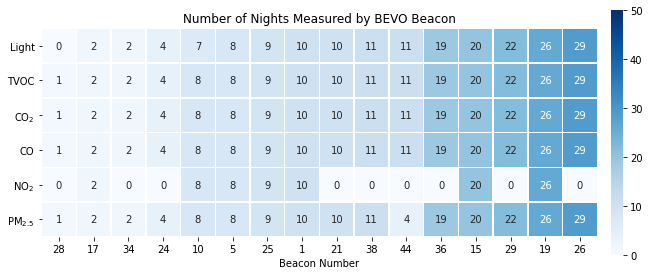

In [76]:
fully_filtered_nights = plot_data_availability_heatmap(beacon_filtered, df_filter='fully', save=True, save_dir="../../papers/5eea5276044b790001ee5687/figures/")

## Combining Percentages
Putting them all together.

In [77]:
indices = ['lux',
 'tvoc',
 'co2',
 'co',
 'no2',
 'pm2p5_mass',
 'total']
pd.DataFrame(overall_op, index=indices)

,During Study,While Operating,Asleep and Home,"Asleep, Home, and EMA"
lux,192.4,81.7,95.6,95.1
tvoc,224.3,95.3,98.6,99.1
co2,228.7,97.2,95.1,95.6
co,227.5,96.7,100.0,99.9
no2,161.2,82.0,88.5,88.4
pm2p5_mass,223.8,95.1,95.6,96.1
total,213.4,92.2,96.2,96.3


# Miscellaneous

## Converting NO2
The literature is split on the units they use to report NO2 concentrations.

In [78]:
def convert_no2_to_ppb(concentration):
    '''
    Converts a ug/m3 NO2 concentration to ppb
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MV/MM

In [79]:
def convert_no2_to_ugm3(concentration):
    '''
    Converts a ppb NO2 concentration to ug/m3
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MM/MV

In [80]:
convert_no2_to_ppb(16.2)

8.628260869565217

In [81]:
convert_no2_to_ugm3(13.8)

25.910204081632656